In [1]:
%load_ext autoreload
%autoreload 2

<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
مدلسازی و حل مسئله
</div>

In [2]:
# ---------------------------------------------------------------------------- #
#                              Import the modules                              #
# ---------------------------------------------------------------------------- #
import pandas as pd
from pyomo.environ import *

# ---------------------------------------------------------------------------- #
#                             Initialize the MODEL                             #
# ---------------------------------------------------------------------------- #
model = ConcreteModel()

machines = [1, 2, 3, 4, 5]
products = [1, 2, 3]
products_dict = {1:"A",2:"B",3:"C"}


# ---------------------------------------------------------------------------- #
#                                Define the SETS                               #
# ---------------------------------------------------------------------------- #
model.machines = RangeSet(1,5)
model.products = RangeSet(1,3)

# ---------------------------------------------------------------------------- #
#                             Define the VARIABLES                             #
# ---------------------------------------------------------------------------- #

model.X = Var(model.machines, model.products, within=NonNegativeIntegers)
model.Y = Var(model.machines, model.products, within=NonNegativeIntegers)
model.P = Var(within=Binary)
model.F1 = Var(within=Binary)
model.F2 = Var(within=Binary)
model.F3 = Var(within=Binary)
model.G = Var(within=Binary)
model.K = Var(within=Binary)
model.Q = Var(within=Binary)

model.L = Var(within=NonNegativeIntegers)

# ---------------------------------------------------------------------------- #
#                         Define the OBJECTIVE FUNCTION                        #
# ---------------------------------------------------------------------------- #
model.objective = Objective(expr=model.L, sense=minimize)

# ---------------------------------------------------------------------------- #
#                               Define the PARAMS                              #
# ---------------------------------------------------------------------------- #

# --------------- Work time for each product with each machine --------------- #
times = pd.read_excel('Time Data.xlsx', index_col=0)

keys = list(times.to_dict().keys())
values = list(times.to_dict().values())

time_params = {(j+1,i):k for i in range(1,len(keys)+1) for j,k in enumerate(values[i-1].values())}
print(time_params)

model.time_params = Param(model.machines, model.products, initialize=time_params, mutable=True)

# ----------------------------------- Big M ---------------------------------- #
model.M = 1e6

# -------------------------- Machines cool down time ------------------------- #
model.machines_cool_down_times = Param(model.machines, initialize = {1:4, 2:10, 3:5, 4:20, 5:0}, mutable=True)

# ---------------------------------------------------------------------------- #
#                            Define the CONSTRAINTS                            #
# ---------------------------------------------------------------------------- #

# -------------------- Linearazation of objective function ------------------- #
model.objective_linear = ConstraintList()
model.objective_linear.add(model.L >= model.Y[4, 1])
model.objective_linear.add(model.L >= model.Y[5, 2])
model.objective_linear.add(model.L >= model.Y[5, 3])

# ---------------------------------- X and Y --------------------------------- #
model.start_and_end_time_relation = ConstraintList()
for machine in machines:
    for product in products:
        model.start_and_end_time_relation.add(model.Y[machine, product] >= model.X[machine, product])
        model.start_and_end_time_relation.add(model.X[machine, product] + model.time_params[machine, product] == model.Y[machine, product])

# ----------- Each product must pass through machines sequentially ----------- #
model.sequentials = ConstraintList()
for j in products:
    for i in range(1,len(machines)):
        model.sequentials.add(model.Y[i, j] <= model.X[i+1, j])
model.sequentials.add(model.Y[5, 2] <= model.Y[5, 3] + 15)

# ------------------------------- A finish time ------------------------------ #
model.A_finish_time = Constraint(expr = model.Y[4, 1] <= 60)

# --------------------- Machines can do one thing at once -------------------- #
model.interferences = ConstraintList()

# Machine 1
model.interferences.add(expr = model.X[1, 1] - model.Y[1, 2] >= model.machines_cool_down_times[1] - model.M*model.P)
model.interferences.add(expr = model.X[1, 2] - model.Y[1, 1] >= model.machines_cool_down_times[1] - model.M*(1 - model.P))

# Machine 2
model.interferences.add(expr = model.X[2, 2] - model.Y[2, 1] >= model.machines_cool_down_times[2] - model.M*model.F1)
model.interferences.add(expr = model.X[2, 1] - model.Y[2, 2] >= model.machines_cool_down_times[2] - model.M*(1 - model.F1))
model.interferences.add(expr = model.X[2, 3] - model.Y[2, 1] >= model.machines_cool_down_times[2] - model.M*model.F2)
model.interferences.add(expr = model.X[2, 1] - model.Y[2, 3] >= model.machines_cool_down_times[2] - model.M*(1 - model.F2))
model.interferences.add(expr = model.X[2, 2] - model.Y[2, 3] >= model.machines_cool_down_times[2] - model.M*model.F3)
model.interferences.add(expr = model.X[2, 3] - model.Y[2, 2] >= model.machines_cool_down_times[2] - model.M*(1 - model.F3))

# Machine 3
model.interferences.add(expr = model.X[3, 3] - model.Y[3, 1] >= model.machines_cool_down_times[3] - model.M*model.G)
model.interferences.add(expr = model.X[3, 1] - model.Y[3, 3] >= model.machines_cool_down_times[3] - model.M*(1 - model.G))

# Machine 4
model.interferences.add(expr = model.X[4, 1] - model.Y[4, 2] >= model.machines_cool_down_times[4] - model.M*model.K)
model.interferences.add(expr = model.X[4, 2] - model.Y[4, 1] >= model.machines_cool_down_times[4] - model.M*(1 - model.K))

# Machine 5
model.interferences.add(expr = model.X[5, 2] - model.Y[5, 3] >= model.machines_cool_down_times[5] - model.M*model.Q)
model.interferences.add(expr = model.X[5, 3] - model.Y[5, 2] >= model.machines_cool_down_times[5] - model.M*(1 - model.Q))

# ---------------------------------------------------------------------------- #
#                              Binary constraints                              #
# ---------------------------------------------------------------------------- #
model.binaries = ConstraintList()

model.binaries.add(expr = model.F2 + model.F3 - model.F1 >= 0)
model.binaries.add(expr = model.F2 + model.F3 - model.F1 <= 1)

# ---------------------------------------------------------------------------- #
#                                Solve the model                               #
# ---------------------------------------------------------------------------- #
solver = SolverFactory('cplex')
solver.solve(model)

print(f'objective function : {value(model.objective)}')

for x in model.machines:
    for y in model.products:
        print(f'value of {model.X[x,y]}={value(model.X[x,y])}')
        print(f'value of {model.Y[x,y]}={value(model.Y[x,y])}')

{(1, 1): 10, (2, 1): 6, (3, 1): 12, (4, 1): 22, (5, 1): 0, (1, 2): 8, (2, 2): 9, (3, 2): 0, (4, 2): 19, (5, 2): 7, (1, 3): 0, (2, 3): 9, (3, 3): 14, (4, 3): 0, (5, 3): 6}
objective function : 96.0
value of X[1,1]=0.0
value of Y[1,1]=10.0
value of X[1,2]=14.0
value of Y[1,2]=22.0
value of X[1,3]=0.0
value of Y[1,3]=0.0
value of X[2,1]=10.0
value of Y[2,1]=16.0
value of X[2,2]=26.0
value of Y[2,2]=35.0
value of X[2,3]=45.0
value of Y[2,3]=54.0
value of X[3,1]=16.0
value of Y[3,1]=28.0
value of X[3,2]=70.0
value of Y[3,2]=70.0
value of X[3,3]=61.0
value of Y[3,3]=75.0
value of X[4,1]=28.0
value of Y[4,1]=50.0
value of X[4,2]=70.0
value of Y[4,2]=89.0
value of X[4,3]=75.0
value of Y[4,3]=75.0
value of X[5,1]=50.0
value of Y[5,1]=50.0
value of X[5,2]=89.0
value of Y[5,2]=96.0
value of X[5,3]=75.0
value of Y[5,3]=81.0


<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
رسم گانت چارت
</div>

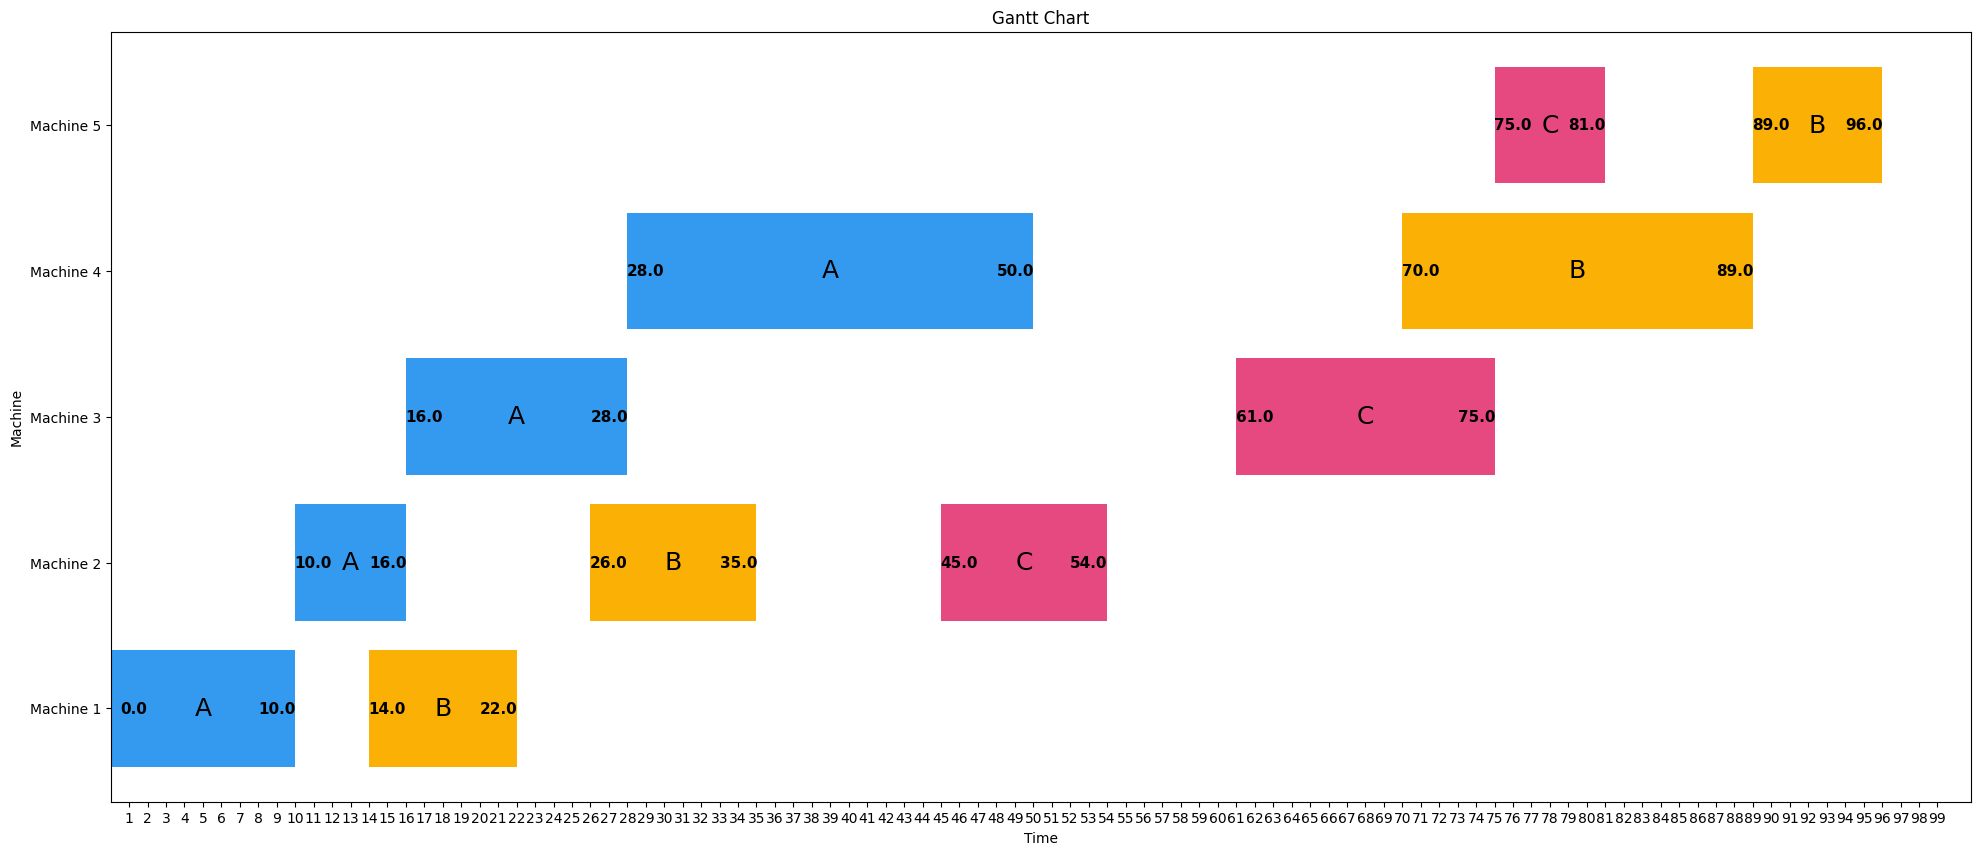

In [3]:
from utils.draw_answer import draw_answer
draw_answer(model)

<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
ذخیره جواب در دیتافریم
</div>

In [4]:
tuples = [(i, j) for i in machines for j in products]
index = pd.MultiIndex.from_tuples(tuples=tuples, name=["machine", "product"])

start_times = [value(model.X[x,y]) for x in model.machines for y in model.products]
end_times = [value(model.Y[x,y]) for x in model.machines for y in model.products]

df = pd.DataFrame([[x,y] for x,y in zip(start_times, end_times)]  , index=index, columns=["Start Time", "End Time"])
df


Start Time  End Time
machine product                      
1       1               0.0      10.0
        2              14.0      22.0
        3               0.0       0.0
2       1              10.0      16.0
        2              26.0      35.0
        3              45.0      54.0
3       1              16.0      28.0
        2              70.0      70.0
        3              61.0      75.0
4       1              28.0      50.0
        2              70.0      89.0
        3              75.0      75.0
5       1              50.0      50.0
        2              89.0      96.0
        3              75.0      81.0

<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
تحلیل حساسیت
</div>

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
زمان لازم برای ماشین کاری روی محصول B توسط ماشین 2
</div>

In [5]:
from utils.solve import solve
from utils.plot_lists import plot_lists

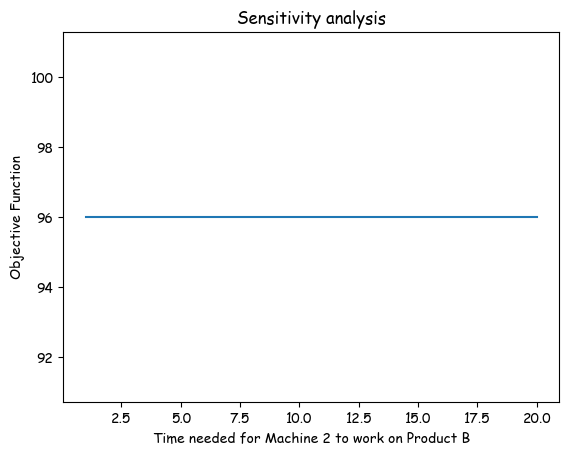

In [6]:
model_1 = model.clone()

answers = []
for i in range(1,20+1):
    model_1.time_params[(2,2)] = i
    answers.append(solve(model_1))

plot_lists(answers, xlabel="Time needed for Machine 2 to work on Product B")

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
 زمان لازم برای ماشین کاری روی محصول A توسط ماشین 4
</div>

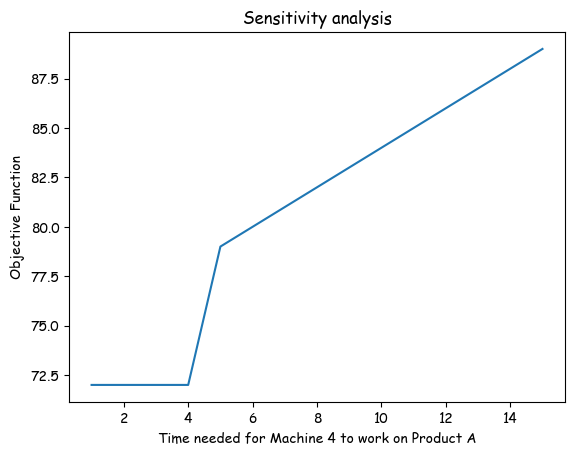

In [7]:
model_2 = model.clone()

answers = []
for i in range(1,15+1):
    model_2.time_params[(4,1)] = i
    answers.append(solve(model_2))

plot_lists(answers, xlabel="Time needed for Machine 4 to work on Product A")

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
 زمان لازم برای ماشین کاری روی محصول C توسط ماشین 5
</div>

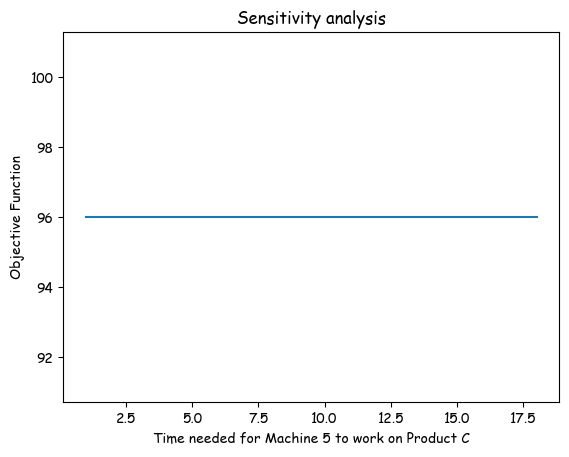

In [8]:
model_3 = model.clone()

answers = []
for i in range(1, 18+1):
    model_3.time_params[(5,3)] = i
    answers.append(solve(model_3))

plot_lists(answers, xlabel="Time needed for Machine 5 to work on Product C")

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
حداکثر زمان مجاز برای تکمیل محصول A
</div>

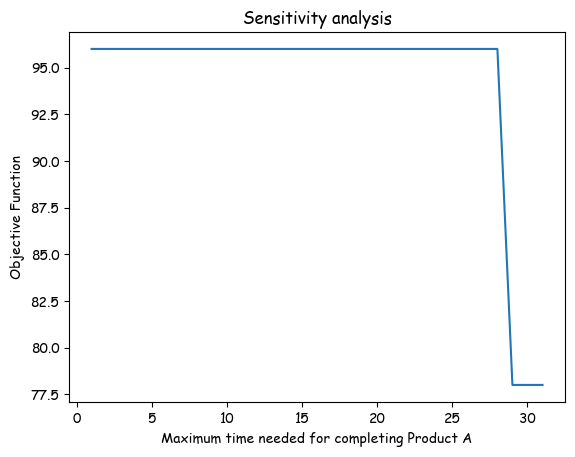

In [9]:
model_4 = model.clone()

answers = []
for k in range(50, 80+1):
    model_4.del_component(model_4.A_finish_time)
    model_4.A_finish_time = Constraint(expr=model_4.Y[4, 1] <= k)
    answers.append(solve(model_4))

plot_lists(answers, xlabel="Maximum time needed for completing Product A")

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
 حداقل زمان لازم برای انجام دو ماشین کاری متوالی روی ماشین 2
</div>

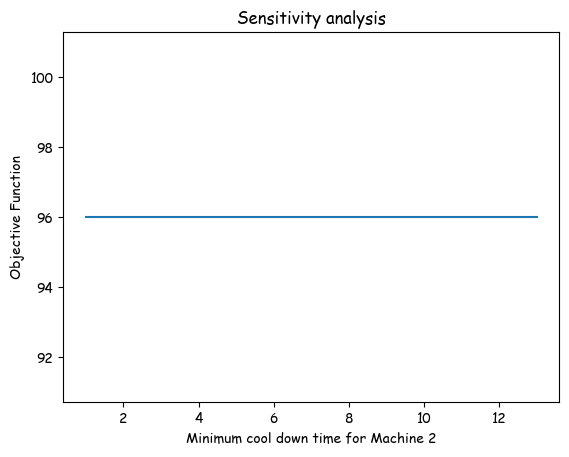

In [10]:
model_5 = model.clone()

answers = []
for k in range(3, 15+1):
    model_5.machines_cool_down_times[2] = k
    answers.append(solve(model_5))

plot_lists(answers, xlabel="Minimum cool down time for Machine 2")